In [1]:
import numpy as np
import ot
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import seaborn as sn
import pandas as pd
from pathlib import Path
from sklearn.utils import check_random_state
from sklearn.datasets import make_moons
# User functions
from utils import BaseTransport, GaussianTransport, get_trajectories_for_plotting, get_desiderata, W2_dist
from IPython.display import Markdown

In [2]:
### Global Hyperparameters
n_samples = 300
n_samples_showing = 100
rng = np.random.RandomState(42)

In [3]:
# Setting so that the plots look normal even when using dark-reader
# sn.set_style("whitegrid")
plt.style.use('seaborn-white')
sn.set_context(context="paper")
pal = sn.color_palette("Set1")

# Setting up specifics for plotting + saving
save_figures = True
add_legend = False
add_title = False
add_axis = False
point_alpha_value = 1
trajectory_parms = {'alpha': 0.15, 'linewidth': 2, 'zorder':10}
mpl.rcParams['lines.markersize'] = 8  # a global parameter for marker sizes
X_parms = {'color': pal[1], 'alpha':point_alpha_value, 'marker':'D', 'zorder':20}
Y_parms = {'color': pal[0], 'alpha':point_alpha_value, 'marker':'v', 'zorder':0}
Z_parms = {'color': pal[2], 'alpha':point_alpha_value, 'marker':'^', 'zorder':30}
save_parms = {'format': 'pdf','bbox_inches':'tight', 'pad_inches':0, 'transparent':True}
contour_parms = {'linewidths':3}
cluster_markers = list('8s*Xd.HP')  # a list of keywords for matploblib markers 
if save_figures:
    figure_dir = Path('.') / 'figures' / 'main-figure'  # saves all figures in a figure directory in the local directory
    if not figure_dir.exists():
        figure_dir.mkdir(parents=True)

In [4]:
def gaussian_contour_plot(X, mean, cov, label, colors, contour_kwargs=None, show=False, legend=False):
    # Ploting contours of the true given normal distribution
    x_min = np.min(X[:, 0]) - 0.25 * np.max(X[:, 0].std())
    y_min = np.min(X[:, 1]) - 0.25 * np.max(X[:, 1].std())
    x_max = np.max(X[:, 0]) + 0.25 * np.max(X[:, 0].std())
    y_max = np.max(X[:, 1]) + 0.25 * np.max(X[:, 1].std())

    xx = np.linspace(x_min, x_max, 100)
    yy = np.linspace(y_min, y_max, 100)
    XX, YY = np.meshgrid(xx, yy)
    coordinates = np.array([XX.flatten(), YY.flatten()]).T

    
    coordinate_probabilities = multivariate_normal(mean, cov).pdf(coordinates)
    if contour_kwargs:
        contour_plot = plt.contour(XX, YY, coordinate_probabilities.reshape(XX.shape),
                                   cmap=colors, **contour_kwargs)
    else:
        contour_plot = plt.contour(XX, YY, coordinate_probabilities.reshape(XX.shape),
                           cmap=colors, linewidths=2)
    contour_plot.collections[-3].set_label(label)
    if legend: plt.legend(loc='lower right')
    if show: plt.show()
    return None

# Explaining Gaussian Shifts
Here we are going to look at simple Gaussian shifts to cover two cases which illuminate the tradeoffs between the two atomic dataset shift explanation techinques: feature constrained shift and clustering. We will start with the simplest shift which is mean shift and then a shifted guassian mixture model

## Gaussian Mixture Model

In [5]:
from sklearn.mixture import GaussianMixture

[[10.          0.        ]
 [ 3.09016994  9.51056516]
 [-8.09016994  5.87785252]
 [-8.09016994 -5.87785252]
 [ 3.09016994 -9.51056516]]
[[ 23.           3.        ]
 [  9.18033989  22.02113033]
 [-24.18033989  13.75570505]
 [-10.18033989 -15.75570505]
 [ 10.18033989 -17.02113033]]


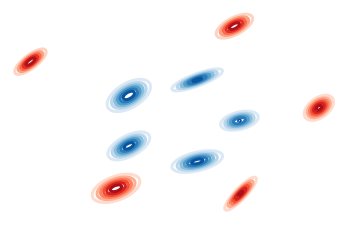

Fid: 179.308, Par: 0.000, Inter: max


In [6]:
def generate_gaussian_mixture_circle(n_mixtures, n_samples_per_mixture, radius,
                                     return_parms=False, rng=None, jitter=False, force_jitter=None):
    # Generates an evenly distributed circle of gaussian distributions with a defined radius and a random cov
    rng = check_random_state(rng)
    # generating means of a each mixture, where each mean is a point on a circle with given radius
    uniform_pis = [2*np.pi * (i / n_mixtures) for i in range(n_mixtures)]
    if jitter is not False:
        jitter_scale = jitter
        jitter = np.zeros((n_mixtures, 2))
        for mixture_idx in range(n_mixtures):
            if rng.randint(0, 4) == 1:  # 25 % chance
                jitter[mixture_idx] = rng.beta(2, 5, size=2) * jitter_scale
            elif rng.randint(0, 3) == 2:  # 33 % chance
                jitter[mixture_idx] = rng.beta(5, 2, size=2) * jitter_scale
            else:
                jitter[mixture_idx] = np.zeros((2))
    else:
        jitter =  np.zeros((n_mixtures, 2))

    if force_jitter is not None:
        assert isinstance(force_jitter, list) and isinstance(force_jitter[0], list)
        for element in force_jitter:
            jitter[element[0]] = element[1]
    mixture_centers = np.zeros((n_mixtures, 2))
    mixture_centers[:, 0], mixture_centers[:, 1] = np.cos(uniform_pis)*radius, np.sin(uniform_pis)*radius
    mixture_centers += jitter
    print(mixture_centers)
    # generating a gaussian distribution for each mixture
    X = np.zeros((n_mixtures*n_samples_per_mixture, 2))  # 2_dims
    mixture_parameters = []
    mixture_labels = np.zeros(X.shape[0])
    for mixture_idx in range(n_mixtures):
        mixture_slice = [mixture_idx*n_samples_per_mixture, (mixture_idx+1)*n_samples_per_mixture]
        mixture_cov = rng.rand(2, 2) + np.eye(2)
        mixture_cov = mixture_cov @ mixture_cov.T
        X[mixture_slice[0]:mixture_slice[1]] = rng.multivariate_normal(mean=mixture_centers[mixture_idx],
                                                           cov=mixture_cov, size=n_samples_per_mixture)
        mixture_parameters.append( [mixture_centers[mixture_idx], mixture_cov] )
        mixture_labels[mixture_slice[0]: mixture_slice[1]] = mixture_idx
    if return_parms:
        return X, mixture_parameters, mixture_labels
    else:
        return X

# for mixture_to_jitter in range(5):
# Hyper parameters
n_mixtures = 5
n_samples_per_mixture = 300
circle_radius = 10  # the radius of the circle of gaussians

X, X_mixture_parms, mixture_labels = generate_gaussian_mixture_circle(n_mixtures, n_samples_per_mixture,
                                                    circle_radius, rng=101, return_parms=True)
Y, Y_mixture_parms, _ = generate_gaussian_mixture_circle(n_mixtures, n_samples_per_mixture,
                                    circle_radius*2, rng=42, return_parms=True, jitter=2, force_jitter=[[0, [3, 3]],
                                                                                                        [1, [3, 3]],
                                                                                                        [2, [-8, 2]],
                                                                                                        [3, [6, -4]],
                                                                                                        [4, [4, 2]]])
# Since it can be confusing/ugly if we plot all samples we are only going to plot a random subset for clarity
points_to_show = rng.choice(X.shape[0], size=n_samples_showing, replace=False)

#### Generating contour plot for mixture models
mixture_parms = contour_parms.copy()
mixture_parms['levels'] = 6
for mixture_idx in range(n_mixtures):
    gaussian_contour_plot(X[mixture_labels==mixture_idx], X_mixture_parms[mixture_idx][0], X_mixture_parms[mixture_idx][1],
                        label='Source', colors='Blues', contour_kwargs=mixture_parms)

    gaussian_contour_plot(Y[mixture_labels==mixture_idx], Y_mixture_parms[mixture_idx][0], Y_mixture_parms[mixture_idx][1],
                        label='Target', colors='Reds', contour_kwargs=mixture_parms)
if add_title: plt.title(fr'Gussian Mixture Model Components')
if not add_axis: plt.axis('off')
if add_legend: plt.legend()
if save_figures: plt.savefig(figure_dir / f'main-figure-gaussian-mixture-model-components-untouched.{save_parms["format"]}', **save_parms)
plt.show()
_ = get_desiderata(X, Y, Z=X, inter='max')

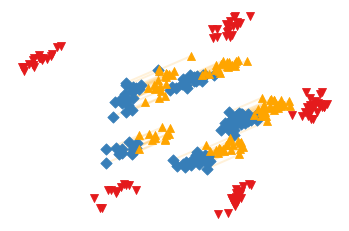

Fid: 197.042, Par: 63129.273, Inter: 1
The mean has shifted by [1.63 1.21]





RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
/home/min/a/skulinsk/miniconda3/envs/py37/lib/python3.7/site-packages/ot/lp/__init__.py:421: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


In [7]:
mixture_points_to_show = rng.choice(X.shape[0], size=n_samples_showing, replace=False)

# Showing pure mean shift:
Z = X + (Y.mean(axis=0) - X.mean(axis=0)) + [4, 2]  # adding [4,2] to make the difference more noticeable (by reducing overlap)

Z_trajectories = get_trajectories_for_plotting(X[mixture_points_to_show],
                                               Z[mixture_points_to_show])

plt.plot(*Z_trajectories, **trajectory_parms, color='orange')
plt.scatter(*X[mixture_points_to_show].T, label='X', **X_parms)
plt.scatter(*Y[mixture_points_to_show].T, label='Y', **Y_parms)
mean_shift_parms = {**Z_parms}
mean_shift_parms['color'] = 'orange'
plt.scatter(*Z[mixture_points_to_show].T, label=r'$T_\mu (X)', **mean_shift_parms)



if add_title: plt.title(f'Mean Shift Transport')
if not add_axis: plt.axis('off')
if add_legend: plt.legend()
if save_figures: plt.savefig(figure_dir / f'main-figure-pure-mean-shift-{n_mixtures}-mixtures.{save_parms["format"]}', **save_parms)
plt.show()
# getting desiderata information
get_desiderata(X, Y, Z, inter=1)
with np.printoptions(precision=2):
    print(f'The mean has shifted by {Y.mean(axis=0) - X.mean(axis=0)}')
print('\n\n')

<span style="color: #1ac938">C_src_0 has shifted by [1.63 1.21]</span>

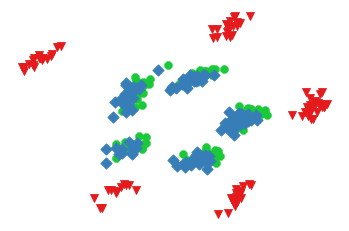

Fid: 175.288, Par: 6222.596, Inter: 1





RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
/home/min/a/skulinsk/miniconda3/envs/py37/lib/python3.7/site-packages/ot/lp/__init__.py:421: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


<span style="color: #1ac938">C_src_0 has shifted by [ 5.93 -4.82]</span>

<span style="color: #8b2be2">C_src_1 has shifted by [-4.81 10.27]</span>

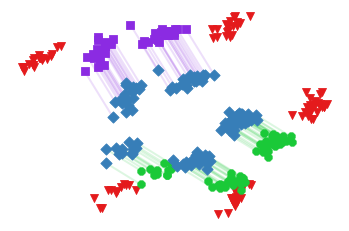

Fid: 92.825, Par: 129724.383, Inter: 2





<span style="color: #1ac938">C_src_0 has shifted by [9.6  7.73]</span>

<span style="color: #8b2be2">C_src_1 has shifted by [ 2.41 -8.67]</span>

<span style="color: #9f480">C_src_2 has shifted by [-15.84   7.97]</span>

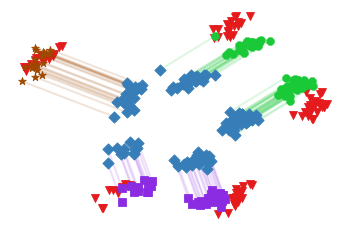

Fid: 23.282, Par: 234037.915, Inter: 3





<span style="color: #1ac938">C_src_0 has shifted by [-15.84   7.97]</span>

<span style="color: #8b2be2">C_src_1 has shifted by [12.96  2.85]</span>

<span style="color: #9f480">C_src_2 has shifted by [ 2.4  -8.67]</span>

<span style="color: #f14cc1">C_src_3 has shifted by [ 6.22 12.56]</span>

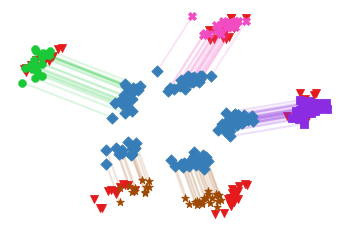

Fid: 9.438, Par: 254804.445, Inter: 4





<span style="color: #1ac938">C_src_0 has shifted by [ 6.95 -7.8 ]</span>

<span style="color: #8b2be2">C_src_1 has shifted by [-15.84   7.97]</span>

<span style="color: #9f480">C_src_2 has shifted by [ 6.22 12.56]</span>

<span style="color: #f14cc1">C_src_3 has shifted by [-2.13 -9.55]</span>

<span style="color: #a3a3a3">C_src_4 has shifted by [12.98  2.89]</span>

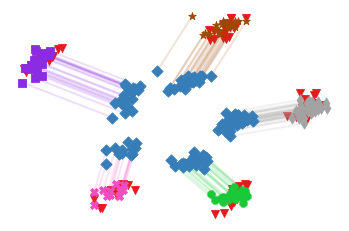

Fid: 0.789, Par: 267778.163, Inter: 5





In [8]:
# The same result as above, but in color this time!

def col_print(s, col):
    color = ''
    for c in col:
        color += str(hex(int(c*255)))[2:]
    display (Markdown(f'<span style="color: #{color}">{s}</span>'))

og_pal = sn.color_palette('Set1')
pal = list(sn.color_palette("bright"))
pal.pop(3)  # removing the red
X_parms = {'color': og_pal[1], 'alpha':point_alpha_value, 'marker':'D', 'zorder':20}
Y_parms = {'color': og_pal[0], 'alpha':point_alpha_value, 'marker':'v', 'zorder':0}
Z_parms = {'color': pal[2], 'alpha':point_alpha_value, 'marker':'^', 'zorder':30}

# Fixing the number of a mixture components and increasing the number of clusters
# to see the increase in fidelity and decrease in interpretability

T = BaseTransport(X, Y)
Z_OT = T.forward(X, Y)
for n_clusters in range(1, n_mixtures+1):
    plt.scatter(*Y[mixture_points_to_show].T, label='Y', **Y_parms)
    Z_clusters, labels = T.cluster_forward(X, n_clusters, unconstrained_Z=Z_OT, return_labels=True)
    for cluster_idx in range(n_clusters):
        # plotting
        cluster_points_to_show = mixture_points_to_show[labels[mixture_points_to_show] == cluster_idx]
#         plt.scatter(*X[cluster_points_to_show].T, label=f'$X_{cluster_idx}$',
#                     color=pal[cluster_idx+1], alpha=X_parms['alpha'], marker=cluster_markers[cluster_idx])
        plt.scatter(*X[cluster_points_to_show].T, label=f'$X_{cluster_idx}$', **X_parms)
        plt.scatter(*Z_clusters[cluster_points_to_show].T, label=f'$T(C_{{X_{cluster_idx}}})$',
                    color=pal[cluster_idx+2], alpha=Z_parms['alpha'], marker=cluster_markers[cluster_idx])
#         plt.scatter(*Z_clusters[cluster_points_to_show].T, label=f'$T(C_{{X_{cluster_idx}}})$',
#                     color=Z_parms['color'], alpha=Z_parms['alpha'], marker=cluster_markers[cluster_idx])
        cluster_trajactories = get_trajectories_for_plotting(X[cluster_points_to_show],
                                                             Z_clusters[cluster_points_to_show])
        plt.plot(*cluster_trajactories, color=pal[cluster_idx+2], **trajectory_parms)
#         plt.plot(*cluster_trajactories, color=Z_parms['color'], **trajectory_parms)
        with np.printoptions(precision=2):
            cluster_mean_shift =  Z_clusters[cluster_points_to_show].mean(axis=0) - X[cluster_points_to_show].mean(axis=0)
            col_print(f'C_src_{cluster_idx} has shifted by {cluster_mean_shift}', pal[cluster_idx+2])
    
    if add_title: plt.title(f'Mean Shift Transport of Clusters, $k={n_clusters}$')
    if not add_axis: plt.axis('off')
    if add_legend: plt.legend()
    if save_figures: plt.savefig(figure_dir / f'main-figure-cluster-transport-{n_clusters}-clusters-{n_mixtures}-mixtures.{save_parms["format"]}', **save_parms)
    plt.show()
    # getting desiderata information
    get_desiderata(X, Y, Z_clusters, inter=n_clusters)
    print('\n\n')